# DyGIE++ co-occurrence network generation

In [1]:
import jsonlines
import networkx as nx
from itertools import combinations
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["axes.formatter.limits"] = (-99, 99)
from statistics import median
from random import sample
import pandas as pd

## Read in data

In [2]:
with jsonlines.open('../../data/wos_files/drought_and_desiccation_combined_22Mar2024.jsonl') as reader:
    dset_papers = [obj for obj in reader]

In [3]:
paper2drought = {p['UID']: p['is_drought'] for p in dset_papers}
paper2desiccation = {p['UID']: p['is_desiccation'] for p in dset_papers}
paper2year = {p['UID']: p['year'] for p in dset_papers}

In [4]:
with jsonlines.open('../../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    dygiepp_preds = [obj for obj in reader]

## Define util functions
We want to be able to get co-occurrence edges from each document, so let's make a set of functions for it.

In [31]:
def get_single_doc_edges(doc, paper2drought, paper2desiccation):
    """
    Get sentence-level co-occurrence edges dor a single dygiepp-formatted document.
    
    parameters:
        doc, dict: doc to format
        paper2drought, dict: keys are UIDs, values are whether or not it was in the
            drought dataset
        paper2desiccation, dict: keys are UIDs, values are whether or not it was in the
            desiccation dataset

    returns:
        nodes, list: nodes to add
        edges, list: edges to add
    """
    is_drought = paper2drought[doc['doc_key']]
    is_desiccation = paper2desiccation[doc['doc_key']]
    
    all_toks = [tok for sent in doc['sentences'] for tok in sent]
    
    nodes = []
    edges = []
    for sent in doc['predicted_ner']:
        sent_ents = []
        for ent in sent:
            ent_text = ' '.join(all_toks[ent[0]: ent[1]+1]).lower()
#             if '"' in ent_text:
#                 print(doc['doc_key'], ent_text,  all_toks)
            ent_type = ent[2]
            sent_ents.append(ent_text)
            nodes.append((ent_text, {'ent_type': ent_type, 'is_drought': is_drought,
                                    'is_desiccation': is_desiccation, 'doc_of_origin': doc['doc_key'],
                                    'year': paper2year[doc['doc_key']]}))
        node_pairs = combinations(sent_ents, 2)
        node_pairs = [p for p in node_pairs if p[0] != p[1]] # Exclude meaningless edges
        for np in node_pairs:
            edge = (np[0], np[1], {'doc_of_origin': doc['doc_key'],
                                  'is_drought': is_drought,
                                  'is_desiccation': is_desiccation,
                                  'year': paper2year[doc['doc_key']]})
            edges.append(edge)
    return nodes, edges

In [9]:
def coalesce_dset_nodes(doc_node_attrs):
    """
    Combines repeated nodes in the graph. If a node appears multiple times,
    and at least once has the is_drought and another time has the is_desiccation attribute,
    we want the node we include to have both of those attributes. Additionally, we'd like to
    keep track of how often the nodes are mentioned, keep track of the first year of mention, 
    and choose the most frequent entity type if there are multiples reported for a given node.
    We can do all of this by looking at the attribute dicts for each edge and node.

    parameters:
        doc_node_attrs, dict: keys are node names, values are lists of attribute dicts for
            all individual mentions of that node

    returns:
        all_nodes, list: nodes for main graph
    """
    all_nodes = []
    num_w_mults = 0
    for n, attr_dict_list in tqdm(doc_node_attrs.items()):
        earliest_year = min([attrs['year'] for attrs in attr_dict_list])
        is_drought = any([attrs['is_drought'] for attrs in attr_dict_list])
        is_desiccation = any([attrs['is_desiccation'] for attrs in attr_dict_list])
        uids_of_origin = [attrs['doc_of_origin'] for attrs in attr_dict_list]
        num_doc_mentions = len(attr_dict_list)
        num_doc_mentions_per_year = Counter([attrs['year'] for attrs in attr_dict_list])
        ent_types = [attrs['ent_type'] for attrs in attr_dict_list]
        if len(set(ent_types)) > 1:
            ent_type, count = Counter(ent_types).most_common(1)[0]
            num_w_mults += 1
        else:
            ent_type = ent_types[0]
        attrs_dict = {
            'uids_of_origin': uids_of_origin,
            'num_doc_mentions_all_time': num_doc_mentions,
            'is_drought': is_drought,
            'is_desiccation': is_desiccation,
            'ent_type': ent_type,
            'first_year_mentioned': earliest_year
        }
        for year, num_mentions in num_doc_mentions_per_year.items():
            attrs_dict[f'num_mentions_{year}'] = num_mentions
        all_nodes.append((n.strip(), attrs_dict))
    
    print(f'{num_w_mults} of {len(all_nodes)} nodes had multiple entity type choices, the '
         'most common was used.')

    return all_nodes


def coalesce_dset_edges(doc_edge_attrs):
    """
    Combines repeated edges in the graph. If a edge appears multiple times,
    and at least once has the is_drought and another time has the is_desiccation attribute,
    we want the edge we include to have both of those attributes. Additionally, we'd like to
    keep track of how often the edges are mentioned, and keep track of the first year of mention.
    We can do all of this by looking at the attribute dicts for each edge and node.

    parameters:
        doc_edge_attrs, dict: keys are edge names, values are lists of attribute dicts for
            all individual mentions of that edge

    returns:
        all_edges, list: edges for main graph
    """
    all_edges = []
    for epair, attr_dict_list in tqdm(doc_edge_attrs.items()):
        earliest_year = min([attrs['year'] for attrs in attr_dict_list])
        is_drought = any([attrs['is_drought'] for attrs in attr_dict_list])
        is_desiccation = any([attrs['is_desiccation'] for attrs in attr_dict_list])
        uids_of_origin = [attrs['doc_of_origin'] for attrs in attr_dict_list]
        num_doc_mentions = len(attr_dict_list)
        
        all_edges.append((epair[0].strip(), epair[1].strip(), {
            'uids_of_origin': uids_of_origin,
            'num_doc_mentions_all_time': num_doc_mentions,
            'is_drought': is_drought,
            'is_desiccation': is_desiccation,
            'first_year_mentioned': earliest_year
        }))

    return all_edges

In [10]:
def get_dataset_graph(dset, paper2drought, paper2desiccation):
    """
    Get sentence-level co-occurrence edges dor a dygiepp-formatted dataset and
    build a graph.
    
    parameters:
        dset, list of dict: dataset to format
        paper2drought, dict: keys are UIDs, values are whether or not it was in the
            drought dataset
        paper2desiccation, dict: keys are UIDs, values are whether or not it was in the
            desiccation dataset

    returns:
        graph, networkx Graph: graph representation of sentence-level co-occurrence
    """
    # First get doc level ents and edges
    print('\nGetting document-level edges and nodes...')
    doc_level_nodes = []
    doc_level_edges = []
    for doc in tqdm(dset):
        nodes, edges = get_single_doc_edges(doc, paper2drought, paper2desiccation)
        doc_level_nodes.extend(nodes)
        doc_level_edges.extend(edges)
    
    # Get the attr dicts for each node and edge:
    print('\nGetting combined attributes for nodes...')
    doc_node_attrs = defaultdict(list)
    for n, attrs in tqdm(doc_level_nodes):
        doc_node_attrs[n].append(attrs)
    print('\nGetting combined attributes for edges...')
    doc_edge_attrs = defaultdict(list)
    for e1, e2, attrs in tqdm(doc_level_edges):
        doc_edge_attrs[(e1, e2)].append(attrs)
    
    # Now combine the docs they come from, the drought/desiccation attributes:
    print('\nCombining nodes...')
    all_nodes = coalesce_dset_nodes(doc_node_attrs)
    print('\nCombining edges...')
    all_edges = coalesce_dset_edges(doc_edge_attrs)
    
    # Make graph
    print('\nBuilding graph...')
    graph = nx.Graph()
    _ = graph.add_nodes_from(all_nodes)
    _ = graph.add_edges_from(all_edges)
    
    print('\nDone!')
    
    return graph

## Build graph

In [32]:
graph = get_dataset_graph(dygiepp_preds, paper2drought, paper2desiccation)


Getting document-level edges and nodes...


100%|██████████| 81886/81886 [00:07<00:00, 10392.97it/s]



Getting combined attributes for nodes...


100%|██████████| 1340759/1340759 [00:04<00:00, 317352.33it/s]



Getting combined attributes for edges...


100%|██████████| 1988310/1988310 [00:01<00:00, 1174788.79it/s]



Combining nodes...


100%|██████████| 334579/334579 [00:04<00:00, 82844.84it/s] 


22440 of 334579 nodes had multiple entity type choices, the most common was used.

Combining edges...


100%|██████████| 1406222/1406222 [00:12<00:00, 111176.89it/s]



Building graph...

Done!


In [12]:
# Can't save lists as attributes in graphml, so make it into a str:
for n, attrs in graph.nodes(data=True):
    attrs['uids_of_origin'] = ', '.join(attrs['uids_of_origin'])
for e1, e2, attrs in graph.edges(data=True):
    attrs['uids_of_origin'] = ', '.join(attrs['uids_of_origin'])

In [14]:
nx.write_graphml(graph, '../../data/kg/all_drought_dt_co_occurrence_graph_03Jun2024.graphml')

## Characterize graph

In [15]:
print(f'There are {len(graph.nodes)} nodes and {len(graph.edges)} edges in the dataset, giving an '
     f'edge:node ratio of {len(graph.edges)/len(graph.nodes):.2f}')

There are 334482 nodes and 1288999 edges in the dataset, giving an edge:node ratio of 3.85


In [16]:
drought_edges = nx.get_edge_attributes(graph, 'is_drought')
desiccation_edges = nx.get_edge_attributes(graph, 'is_desiccation')
is_both = []
dr_only = []
des_only = []
for epair in drought_edges.keys():
    if drought_edges[epair] and desiccation_edges[epair]:
        is_both.append(epair)
    elif drought_edges[epair] and not desiccation_edges[epair]:
        dr_only.append(epair)
    elif not drought_edges[epair] and desiccation_edges[epair]:
        des_only.append(epair)

print(f'Of the {len(graph.edges)} edges in the graph, {len(is_both)} ({100*(len(is_both)/len(graph.edges)):.2f}%) '
     f'are in both the desiccation and drought datasets, while {len(dr_only)} ({100*(len(dr_only)/len(graph.edges)):.2f}%) '
     f'are drought only, and {len(des_only)} ({100*(len(des_only)/len(graph.edges)):.2f}%) are desiccation only.')

Of the 1288999 edges in the graph, 22001 (1.71%) are in both the desiccation and drought datasets, while 1193130 (92.56%) are drought only, and 73868 (5.73%) are desiccation only.


In [17]:
drought_nodes = nx.get_node_attributes(graph, 'is_drought')
desiccation_nodes = nx.get_node_attributes(graph, 'is_desiccation')
is_both = []
dr_only = []
des_only = []
for n in drought_nodes.keys():
    if drought_nodes[n] and desiccation_nodes[n]:
        is_both.append(n)
    elif drought_nodes[n] and not desiccation_nodes[n]:
        dr_only.append(n)
    elif not drought_nodes[n] and desiccation_nodes[n]:
        des_only.append(n)

print(f'Of the {len(graph.nodes)} nodes in the graph, {len(is_both)} ({100*(len(is_both)/len(graph.nodes)):.2f}%) '
     f'are in both the desiccation and drought datasets, while {len(dr_only)} ({100*(len(dr_only)/len(graph.nodes)):.2f}%) '
     f'are drought only, and {len(des_only)} ({100*(len(des_only)/len(graph.nodes)):.2f}%) are desiccation only.')

Of the 334482 nodes in the graph, 14087 (4.21%) are in both the desiccation and drought datasets, while 299782 (89.63%) are drought only, and 20613 (6.16%) are desiccation only.


Text(0.5, 0.98, 'Distribution of degree')

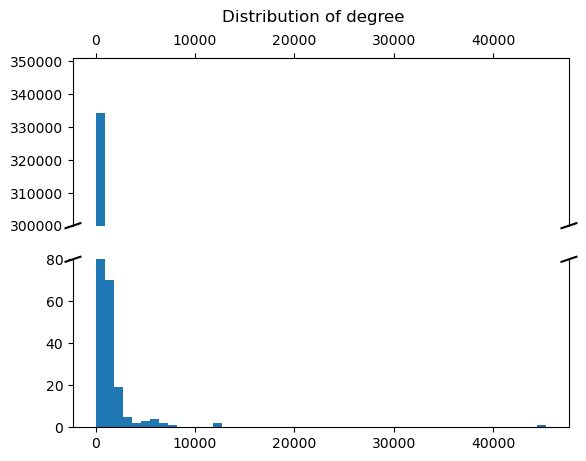

In [18]:
degs = [deg[1] for deg in graph.degree]

# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(degs, bins=50)
_ = ax2.hist(degs, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 80) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.suptitle('Distribution of degree')

In [19]:
most_connected = [deg[0] for deg in graph.degree if deg[1] > 10000]
print(f'The most well-connected entities are: {most_connected}')

The most well-connected entities are: ['water', 'salt', 'aba']


If we exclude the three most connected entities and re-plot the histogram, we see that while the distribution is skewed, it's certainly less bad than in previous graphs we've constructed:

Text(0.5, 0.98, 'Distribution of degree')

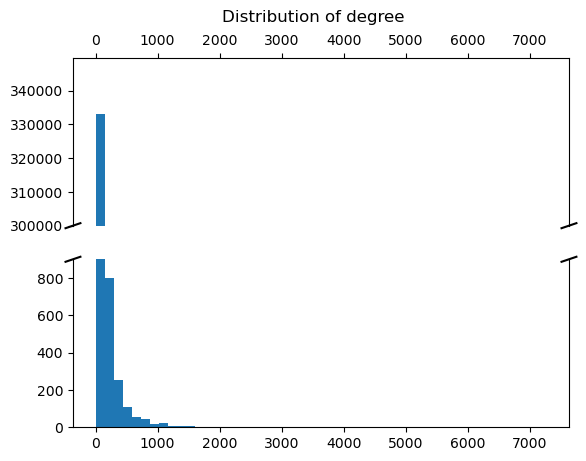

In [20]:
degs = [deg[1] for deg in graph.degree if deg[1] < 10000]

# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(degs, bins=50)
_ = ax2.hist(degs, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 900) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.suptitle('Distribution of degree')

In [21]:
next_most_connected = [deg[0] for deg in graph.degree if 3000 < deg[1] < 10000]
print(f'The next-most well-connected entities are: {next_most_connected}')

The next-most well-connected entities are: ['n', 'wheat', 'rice', 'soybean', 'soil water', 'co2', 'peg', 'proline', 'chlorophyll', 'mda', 'h2o2', 'abscisic acid', 'arabidopsis', 'maize', 'nacl', 'arabidopsis thaliana', 'nitrogen']


We also have weights for how many time each edge and node were mentioned on a per-document basis, let's take a look at the distribution of those values:

In [22]:
node_weights = [attrs['num_doc_mentions_all_time'] for n, attrs in graph.nodes(data=True)]
edge_weights = [attrs['num_doc_mentions_all_time'] for e1, e2, attrs in graph.edges(data=True)]

Text(0.5, 0.98, 'Distribution of node weights')

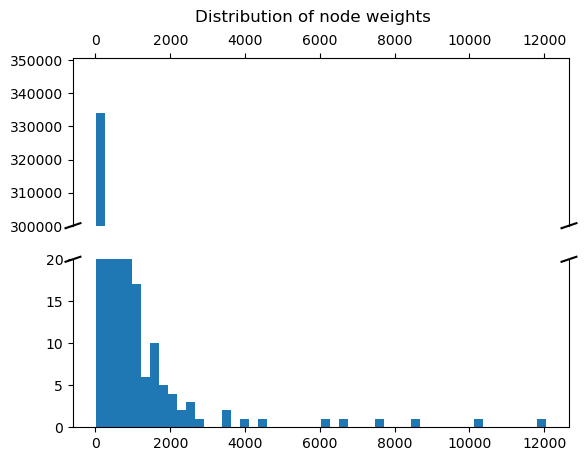

In [23]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(node_weights, bins=50)
_ = ax2.hist(node_weights, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 20) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.suptitle('Distribution of node weights')

In [24]:
most_common_nodes = [n for n, attrs in graph.nodes(data=True) if attrs['num_doc_mentions_all_time'] > 80000]
print(f'The most common node in our dataset is: {most_common_nodes[0]}')

IndexError: list index out of range

In [ ]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(edge_weights, bins=50)
_ = ax2.hist(edge_weights, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 1000) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.suptitle('Distribution of edge weights')

In [ ]:
most_common_edges = [(e1, e2) for e1, e2, attrs in graph.edges(data=True) if attrs['num_doc_mentions_all_time'] > 200]
print('The most common edges in our dataset are:')
for mce in most_common_edges:
    print(mce)

That almost all the most common edges in our graph are related to water is an imporant reminder of the limitations of co-occurrence -- just because two words appear together in the same sentence does not mean they convey information together as a pair, or even that they are actually related (although water clearly is important for plants in this case, that information is so obvious as to be irrelevant)